<a href="https://colab.research.google.com/github/Nzaya/Stock-Price-Prediction/blob/master/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# Load necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [104]:
# Load the dataset

tata = pd.read_csv('/content/NSE-Tata-Global-Beverages-Limited.csv')
tata.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


The Open column is the starting price while the Close column is the final price of a stock on a particular trading day. The High and Low columns represent the highest and lowest prices for a certain day.

#Visualizing each day stock market attributes

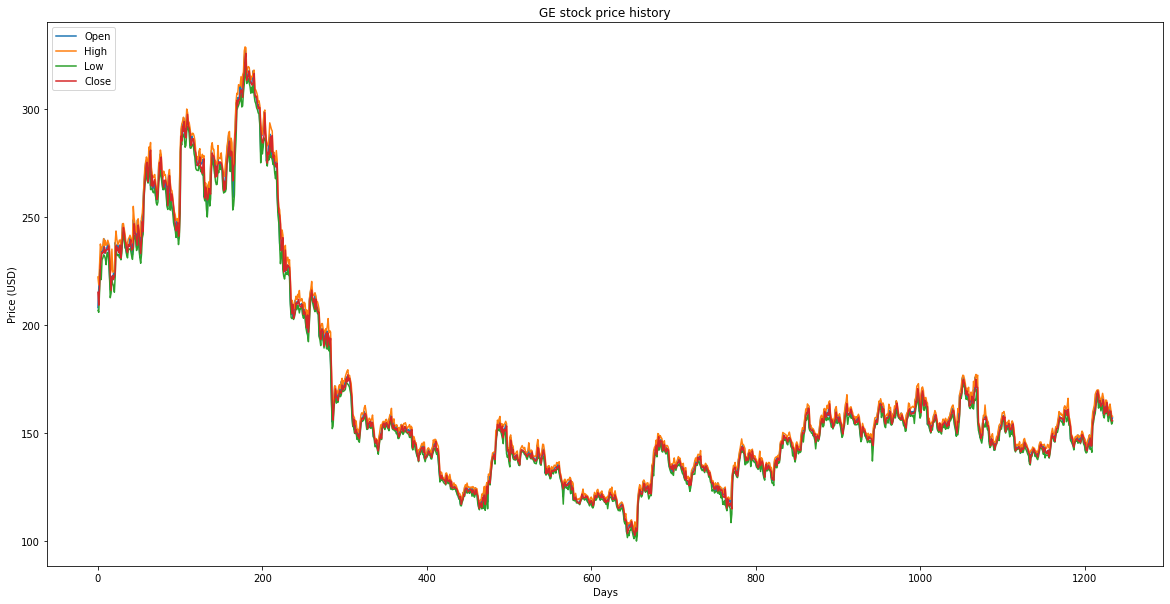

In [105]:

plt.figure()
plt.plot(tata["Open"])
plt.plot(tata["High"])
plt.plot(tata["Low"])
plt.plot(tata["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

It seems the prices — Open, Close, Low, High — don’t vary too much from each other except for occasional slight drops in Low price.

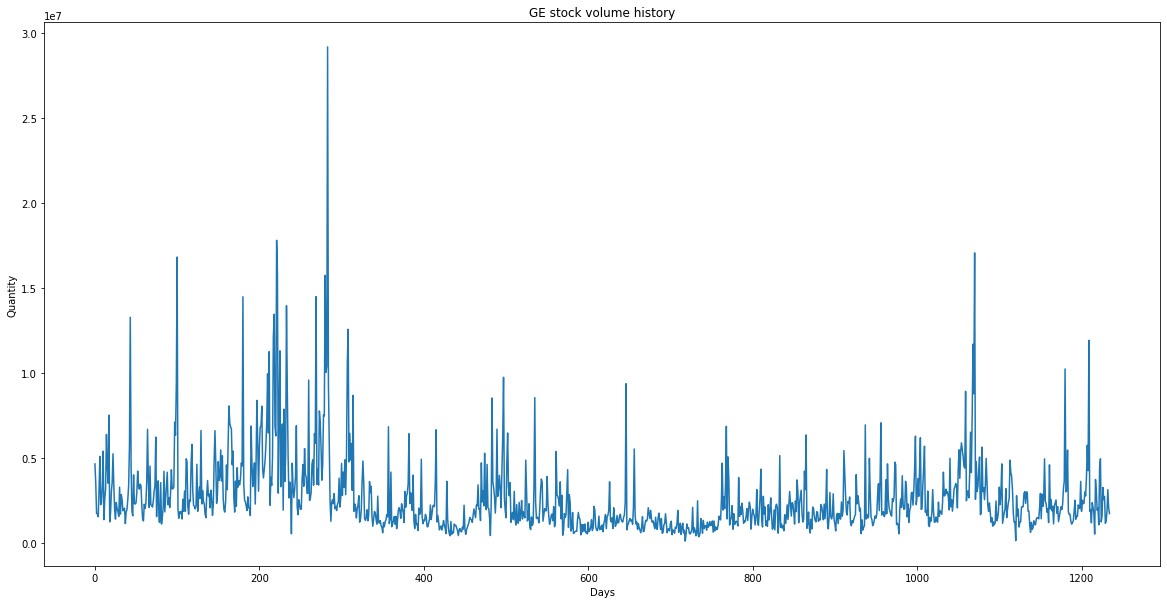

In [108]:
plt.figure()
plt.plot(tata["Total Trade Quantity"])
plt.title('GE stock volume history')
plt.ylabel('Quantity')
plt.xlabel('Days')
plt.show()

There is quite a surge in the number of transactions around 300th and 1100th day on the timeline, which happens to coincide with the sudden drop of stock price.

In [56]:
#Analyze the closing prices 

tata['Date']= pd.to_datetime(tata.Date,format='%Y-%m-%d')
tata.index=tata['Date']

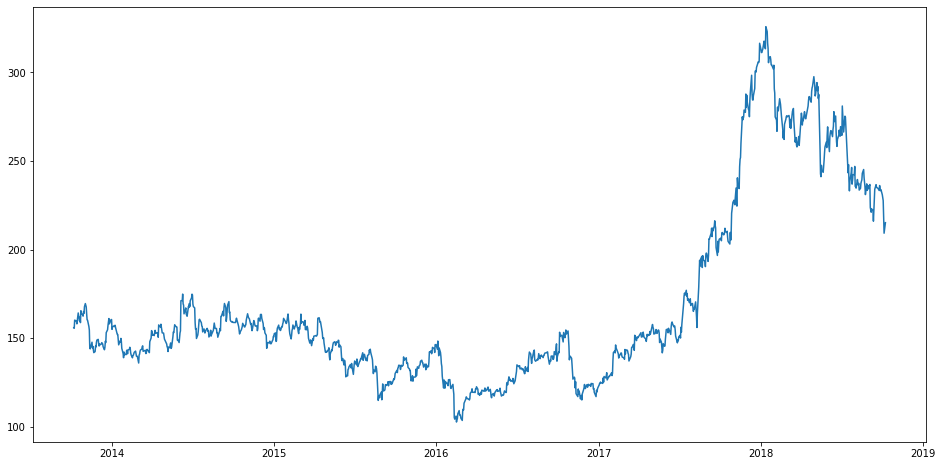

In [57]:
#Plot the analyzation

plt.figure(figsize=(16,8))
plt.plot(tata['Close'], label='Close Price History')

In [67]:
#Sort the dataset on date time and filter "date" and "close" columns

data = tata.sort_index(ascending=True, axis = 0)
df = pd.DataFrame(index=range(0,len(tata)), columns=['Date','Close'])

for i in range(0,len(data)):
  df["Date"][i] = data['Date'][i]
  df["Close"][i] = data["Close"][i]

We have to scale our data for optimal performance. In our case, we’ll use Scikit- Learn’s MinMaxScaler and scale our dataset to numbers between zero and one.

In [68]:
# Normalize the new dataset

scaler = MinMaxScaler(feature_range=(0,1))
final = df.values


# Creating Data with Timesteps

LSTMs expect our data to be in a specific format, usually a 3D array. We start by creating data in 60 timesteps and converting it into an array using NumPy. Next, we convert the data into a 3D dimension array with X_train samples, 60 timestamps, and one feature at each step.

In [69]:

train_data = final[0:987,:]
valid_data = final[987:,:]


In [70]:
df.index = df.Date

In [71]:
df.drop("Date", axis = 1, inplace = True)

In [72]:
scaler= MinMaxScaler(feature_range=(0,1))

In [74]:
scaled_data=scaler.fit_transform(df)

In [75]:
x_train_data,y_train_data=[],[]

In [76]:
for i in range(60,len(train_data)):
  x_train_data.append(scaled_data[i-60:i,0])
  y_train_data.append(scaled_data[i,0])

In [77]:
x_train_data,y_train_data = np.array(x_train_data),np.array(y_train_data)
x_train_data = np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [78]:
# BUild and train the LSTM Model

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences= True, input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [79]:
inputs_data = df[len(df)-len(valid_data)-60:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

In [80]:
lstm_model.compile(loss ='mean_squared_error', optimizer ='adam')
lstm_model.fit(x_train_data,y_train_data, epochs=1, batch_size=1, verbose=2)

927/927 - 19s - loss: 9.1299e-04


In [81]:
# Sample the dataset to make stock prediction using the LSTM model:

X_test=[]
for i in range(60,inputs_data.shape[0]):
  X_test.append(inputs_data[i-60:i,0])
X_test = np.array(X_test)

In [82]:
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))
predicted_closing_price = lstm_model.predict(X_test)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [83]:
#Save the LSTM MOdel

lstm_model.save('saved_model.h5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


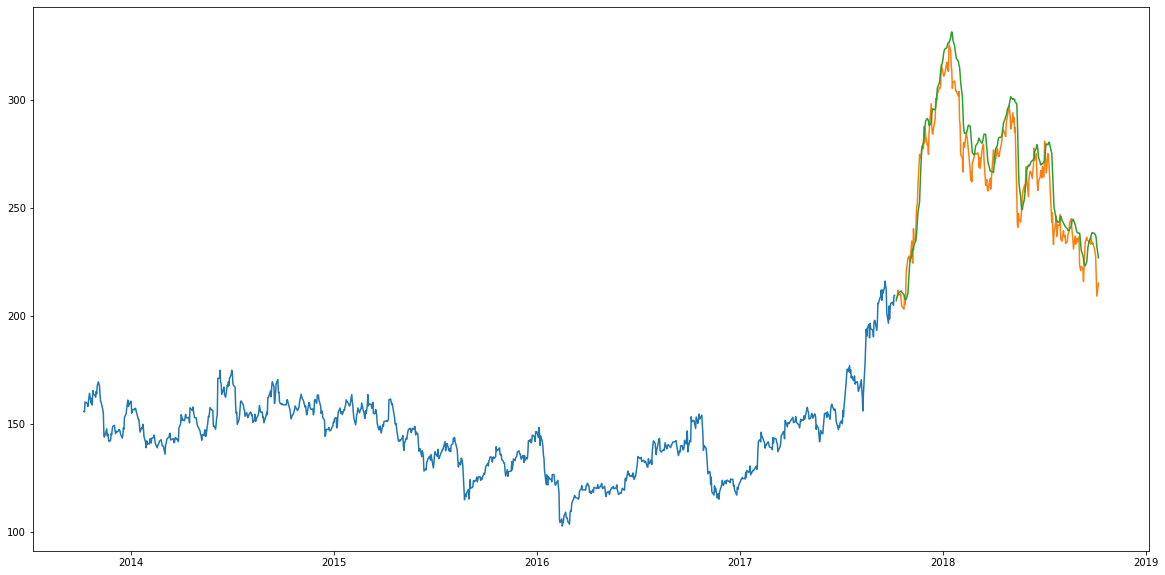

In [84]:
#Visualize the predicted stock cost with actual stock cost

train_data = df[:987]
valid_data = df[987:]
valid_data['Predictions'] = predicted_closing_price
plt.plot(train_data['Close'])
plt.plot(valid_data[['Close','Predictions']])

# Build the dashboard using Plotly dash

In [85]:
# Install necessary libraries

!pip3 install dash

     |████████████████████████████████| 71kB 2.1MB/s 
     |████████████████████████████████| 1.2MB 4.6MB/s 
     |████████████████████████████████| 3.4MB 9.9MB/s 
     |████████████████████████████████| 194kB 14.6MB/s 
     |████████████████████████████████| 1.8MB 12.2MB/s 
     |████████████████████████████████| 358kB 18.7MB/s 
  Created wheel for dash: filename=dash-1.14.0-cp36-none-any.whl size=80129 sha256=4537cfb8febec41ec52d7c6e338730a8683f4ef95248bb5f95b88793a904f780
  Stored in directory: /root/.cache/pip/wheels/1d/54/0b/e846f762d47e8abc9234419822d013dfb2ccf957b48e411dc6
  Created wheel for flask-compress: filename=Flask_Compress-1.5.0-cp36-none-any.whl size=5273 sha256=b5c94cb620dd77c6bf8d59c2a94aa3addfb87e3cfbefb018925d3fa40ef1431d
  Stored in directory: /root/.cache/pip/wheels/f7/e9/e4/5afc286be7c87461375e33152558415dfeb0c8f5af3b50e742
  Created wheel for dash-renderer: filename=dash_renderer-1.6.0-cp36-none-any.whl size=1182221 sha256=886f6375e6ea87bd4760c3aaa872d823363b8f

In [86]:
!pip3 install dash-html-components

In [87]:
!pip3 install dash-core-components

In [88]:
# Load necessary libraries

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from dash.dependencies import  Input, Output
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [89]:
app = dash.Dash()
server = app.server

In [91]:
stock = pd.read_csv('/content/stock_data.csv')
stock.head()

,Date,Open,High,Low,Close,Volume,OpenInt,Stock
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0,AAPL
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0,AAPL
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0,AAPL
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0,AAPL
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0,AAPL


In [92]:
app.layout = html.Div([
   
    html.H1("Stock Price Analysis Dashboard", style={"textAlign": "center"}),
   
    dcc.Tabs(id="tabs", children=[
       
        dcc.Tab(label='NSE-TATAGLOBAL Stock Data',children=[
            html.Div([
                html.H2("Actual closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Actual Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=train_data.index,
                                y=valid_data["Close"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                ),
                html.H2("LSTM Predicted closing price",style={"textAlign": "center"}),
                dcc.Graph(
                    id="Predicted Data",
                    figure={
                        "data":[
                            go.Scatter(
                                x=valid_data.index,
                                y=valid_data["Predictions"],
                                mode='markers'
                            )
                        ],
                        "layout":go.Layout(
                            title='scatter plot',
                            xaxis={'title':'Date'},
                            yaxis={'title':'Closing Rate'}
                        )
                    }
                )                
            ])                
        ]),
        dcc.Tab(label='Facebook Stock Data', children=[
            html.Div([
                html.H1("Facebook Stocks High vs Lows", 
                        style={'textAlign': 'center'}),
              
                dcc.Dropdown(id='my-dropdown',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'}, 
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='highlow'),
                html.H1("Facebook Market Volume", style={'textAlign': 'center'}),
         
                dcc.Dropdown(id='my-dropdown2',
                             options=[{'label': 'Tesla', 'value': 'TSLA'},
                                      {'label': 'Apple','value': 'AAPL'}, 
                                      {'label': 'Facebook', 'value': 'FB'},
                                      {'label': 'Microsoft','value': 'MSFT'}], 
                             multi=True,value=['FB'],
                             style={"display": "block", "margin-left": "auto", 
                                    "margin-right": "auto", "width": "60%"}),
                dcc.Graph(id='volume')
            ], className="container"),
        ])
    ])
])


In [93]:
@app.callback(Output('highlow', 'figure'),
              [Input('my-dropdown', 'value')])
def update_graph(selected_dropdown):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    trace2 = []
    for stock in selected_dropdown:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["High"],
                     mode='lines', opacity=0.7, 
                     name=f'High {dropdown[stock]}',textposition='bottom center'))
        trace2.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Low"],
                     mode='lines', opacity=0.6,
                     name=f'Low {dropdown[stock]}',textposition='bottom center'))
    traces = [trace1, trace2]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data,
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"High and Low Prices for {', '.join(str(dropdown[i]) for i in selected_dropdown)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Price (USD)"})}
    return figure
@app.callback(Output('volume', 'figure'),
              [Input('my-dropdown2', 'value')])
def update_graph(selected_dropdown_value):
    dropdown = {"TSLA": "Tesla","AAPL": "Apple","FB": "Facebook","MSFT": "Microsoft",}
    trace1 = []
    for stock in selected_dropdown_value:
        trace1.append(
          go.Scatter(x=df[df["Stock"] == stock]["Date"],
                     y=df[df["Stock"] == stock]["Volume"],
                     mode='lines', opacity=0.7,
                     name=f'Volume {dropdown[stock]}', textposition='bottom center'))
    traces = [trace1]
    data = [val for sublist in traces for val in sublist]
    figure = {'data': data, 
              'layout': go.Layout(colorway=["#5E0DAC", '#FF4F00', '#375CB1', 
                                            '#FF7400', '#FFF400', '#FF0056'],
            height=600,
            title=f"Market Volume for {', '.join(str(dropdown[i]) for i in selected_dropdown_value)} Over Time",
            xaxis={"title":"Date",
                   'rangeselector': {'buttons': list([{'count': 1, 'label': '1M', 
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'count': 6, 'label': '6M',
                                                       'step': 'month', 
                                                       'stepmode': 'backward'},
                                                      {'step': 'all'}])},
                   'rangeslider': {'visible': True}, 'type': 'date'},
             yaxis={"title":"Transactions Volume"})}
    return figure


In [ ]:
if __name__=='__main__':
    app.run(debug=True, use_reloader=False)

Now run this file and open the app in the browser

In [ ]:
python3 stock_app.py